# Particle MCMC model for COVID-19 in Mexico

This notebook contains all of the Python code needed to use Particle Marginal Markov Chain Monte Carlo to explore the parameter space of our diffusion driven model and estimate the trajectories of the hidden states

In [11]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [651]:
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
weekly_covid_df.head()

,date,confirmed_cases,confirmed_deaths
0,2020-02-23,4.0,0.0
1,2020-03-01,23.0,0.0
2,2020-03-08,131.0,0.0
3,2020-03-15,624.0,0.0
4,2020-03-22,1152.0,6.0


In [652]:
pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.1% of Population: ', np.round(0.001*N).astype(int))


Total Population:  126014024
0.1% of Population:  126014


In [1409]:
stats.beta(7.2, 0.8).rvs()

np.float64(0.7614219079924752)

In [1544]:
# Initial Value Conditions Prior
def set_IVC(N, rho, nu, num_particles):
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)
    E = np.round(stats.uniform(0, np.round(0.001 * N).astype(int)).rvs(num_particles))
    U = np.round(stats.uniform(0, np.round((1 - rho) * nu * E).astype(int)).rvs(num_particles))
    O = np.round(stats.uniform(0, np.round(rho * nu * E).astype(int)).rvs(num_particles))
    E -=  U + O 
    S = N - E - U - O
    
    beta = stats.uniform(0,1).rvs(num_particles)
    mu = stats.uniform(0,1).rvs(num_particles)
    
    return np.vstack([S, E, U, O, R, D, beta, mu])

def set_param_priors():
    alpha = stats.beta(2.3, 96.5).rvs()
    rho = stats.beta(7.2, 0.8).rvs()
    nu = stats.beta(6.9, 14.1).rvs()
    gamma = stats.beta(2.36, 9.44).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    sigma_m = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(50,scale=100).rvs()
    psi_d = stats.gamma(50,scale=100).rvs()
    
    return [alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d]
    

In [1727]:
T = 200
h = 0.1
num_steps = int(T / h)
num_particles=500

# Initialize arrays to store results
time = np.linspace(0, T, num_steps)
X = np.zeros([8,num_particles,num_steps])
Z1 = np.zeros([num_particles, num_steps])
Z2 = np.zeros([num_particles, num_steps])

# Set initial conditions
alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d = set_param_priors()
X[:,:,0] = set_IVC(N, rho, nu, num_particles)
Z1[:,0] = np.log(X[6,:,0]+ 1e-10)
Z2[:,0] = np.log(X[7,:,0]+ 1e-10)

# Simulate the SIR model with stochastic beta using Euler-Maruyama method
for t in range(1, num_steps):
    # Sample Brownian increment
    dB1 = stats.norm(0,1).rvs(num_particles)
    dB2 = stats.norm(0,1).rvs(num_particles)
    # Update Z using Euler-Maruyama method
    Z1[:,t] = Z1[:,t-1] + sigma_b * np.sqrt(h) * dB1 
    Z2[:,t] = Z2[:,t-1] + sigma_m * np.sqrt(h) * dB2
    # Update time-varying parameter values
    X[6,:,t] = 1 / (1 + np.exp(-Z1[:, t])) # np.exp(Z1[:,t]) #update beta(t)
    X[7,:,t] = 1 / (1 + np.exp(-Z2[:, t])) # np.exp(Z2[:,t]) #update mu(t)   
    
    #Update SEUORDS model
    X[0,:,t] =  X[0,:,t-1] + (-X[6,:,t]*(X[2,:,t-1] + X[3,:,t-1])*X[0,:,t-1]/N + alpha*X[4,:,t-1])*h   # S-Susceptibles
    X[1,:,t] =  X[1,:,t-1] + (X[6,:,t]*(X[2,:,t-1] + X[3,:,t-1])*X[0,:,t-1]/N - nu*X[1,:,t-1])*h       # E-Exposed
    X[2,:,t] =  X[2,:,t-1] + ((1-rho)*nu*X[1,:,t-1] - gamma*X[2,:,t-1])*h                              # U-Unobserved
    X[3,:,t] =  X[3,:,t-1] + (rho*nu*X[1,:,t-1] - gamma*X[3,:,t-1] - X[7,:,t]*X[3,:,t-1])*h            # O-Observed
    X[4,:,t] =  X[4,:,t-1] + (gamma*(X[2,:,t-1] + X[3,:,t-1]) - alpha*X[4,:,t-1])*h                    # R-Recovered
    X[5,:,t] =  X[5,:,t-1] + (X[7,:,t]*X[3,:,t-1])*h                                                   # D-Death

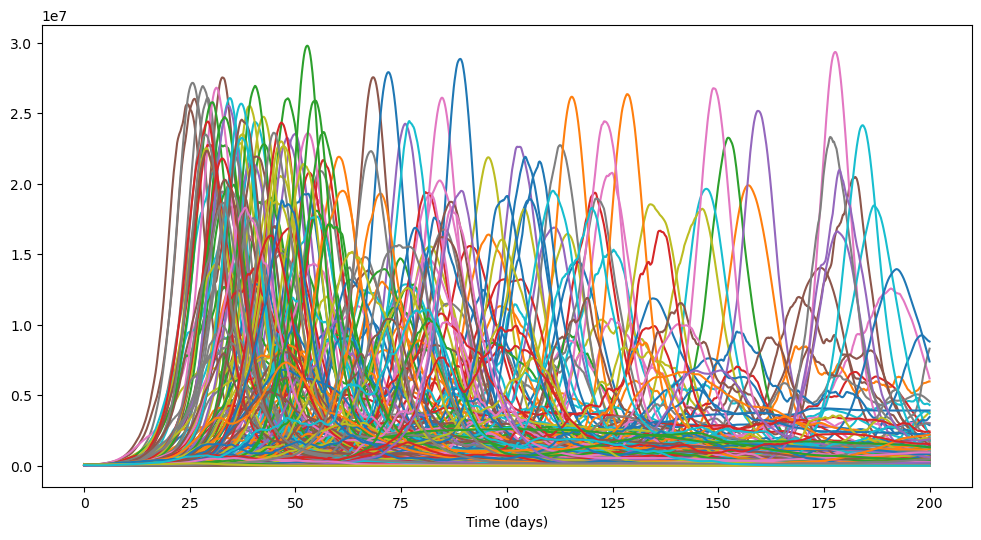

In [1728]:
plt.figure(figsize=(12,6))
for p in range(num_particles):
    plt.plot(time,X[1, p, :])
    plt.xlabel('Time (days)')
plt.show()